<a href="https://colab.research.google.com/github/Akina-Ino/Anomaly-features-MQTT/blob/main/MQTTset_%2B_DoS_%2B_Flood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geral


Top 10 features mais importantes para detectar ataques (SVM):
                       Feature      Coef  Importance
32        tcp.flags_0x00000018 -0.995462    0.995462
28        tcp.flags_0x00000010 -0.982537    0.982537
43    mqtt.hdrflags_0x00000040  0.476268    0.476268
50                mqtt.msg_0.0  0.331864    0.331864
16                mqtt.msgtype  0.241112    0.241112
1                      tcp.len  0.152467    0.152467
8824         mqtt.msg_74657374  0.124343    0.124343
47    mqtt.hdrflags_0x000000c0 -0.119286    0.119286
18                    mqtt.qos  0.115956    0.115956
14                    mqtt.len  0.112309    0.112309


/tmp/ipython-input-3-2607481287.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')


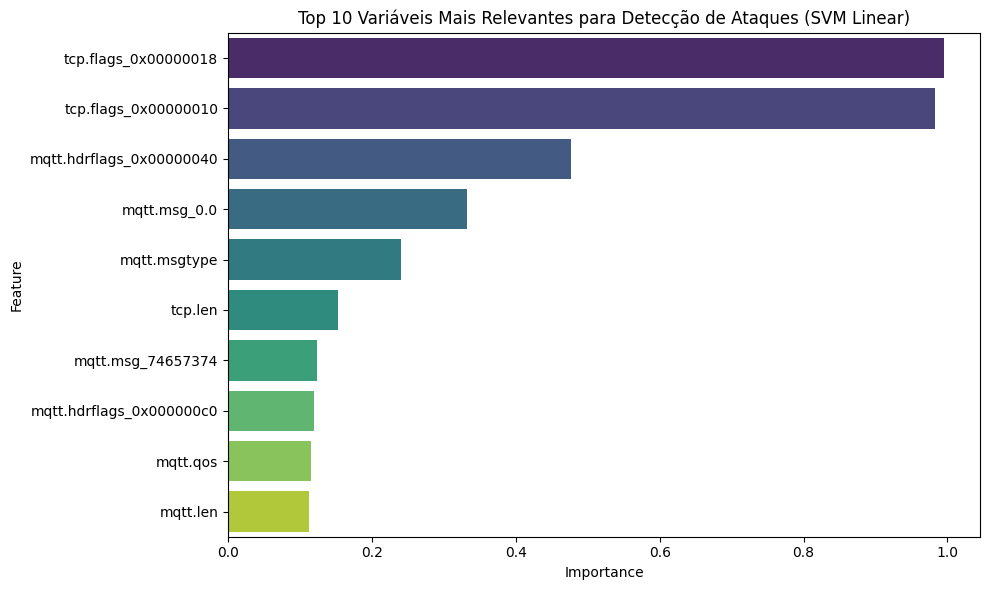


Relatório de Classificação - SVM:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      7458
           1       1.00      0.73      0.85      7542

    accuracy                           0.87     15000
   macro avg       0.89      0.87      0.86     15000
weighted avg       0.89      0.87      0.86     15000

Acurácia SVM: 0.8651


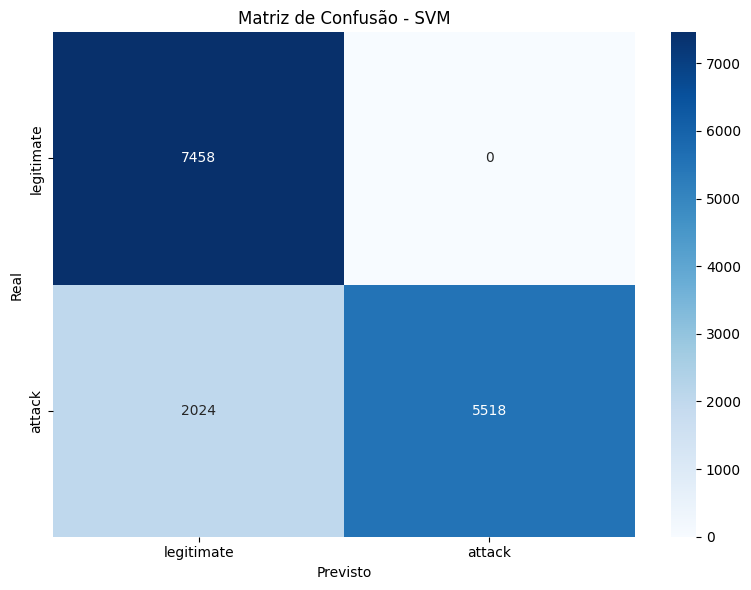


Relatório de Classificação - KNN:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      7458
           1       0.99      0.92      0.95      7542

    accuracy                           0.95     15000
   macro avg       0.96      0.95      0.95     15000
weighted avg       0.96      0.95      0.95     15000

Acurácia KNN: 0.9542

Top 10 features com maior diferença média entre classes (KNN):
mqtt.hdrflags_0x00000030: Diferença média = 1.3125
mqtt.msgid: Diferença média = 1.0768
mqtt.qos: Diferença média = 0.8960
mqtt.len: Diferença média = 0.8250
mqtt.hdrflags_0x00000040: Diferença média = 0.7335
mqtt.msg_30: Diferença média = 0.7290
mqtt.hdrflags_0x00000032: Diferença média = 0.6942
mqtt.msg_31: Diferença média = 0.5599
mqtt.msg_32: Diferença média = 0.5201
mqtt.dupflag: Diferença média = 0.5040


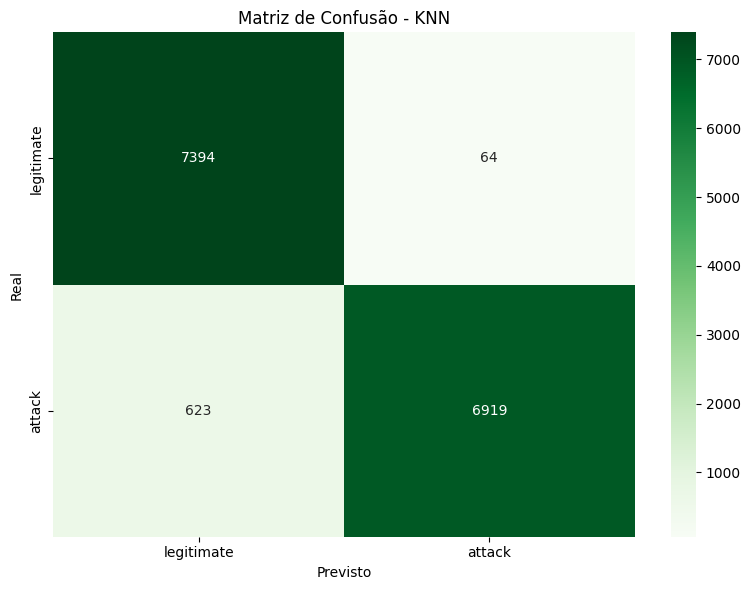


RESUMO COMPARATIVO:
Acurácia SVM: 0.8651
Acurácia KNN: 0.9542


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# === 1. Carregar somente as colunas necessárias ===
usecols = [
    'tcp.flags','tcp.time_delta','tcp.len','mqtt.conack.flags','mqtt.conack.flags.reserved',
    'mqtt.conack.flags.sp','mqtt.conack.val','mqtt.conflag.cleansess','mqtt.conflag.passwd',
    'mqtt.conflag.qos','mqtt.conflag.reserved','mqtt.conflag.retain','mqtt.conflag.uname',
    'mqtt.conflag.willflag','mqtt.conflags','mqtt.dupflag','mqtt.hdrflags','mqtt.kalive',
    'mqtt.len','mqtt.msg','mqtt.msgid','mqtt.msgtype','mqtt.proto_len','mqtt.protoname',
    'mqtt.qos','mqtt.retain','mqtt.sub.qos','mqtt.suback.qos','mqtt.ver','mqtt.willmsg',
    'mqtt.willmsg_len','mqtt.willtopic','mqtt.willtopic_len','target'
]

df = pd.read_csv("/content/mqttdataset_reduced.csv", usecols=usecols, nrows=50000)

# === 2. Converter a coluna 'target' para binária ===
df['target'] = df['target'].astype(str).str.strip().str.lower().apply(lambda x: 0 if x == 'legitimate' else 1)

# === 3. Remover linhas com dados ausentes (NaN) ===
df.dropna(inplace=True)

# === 4. Separar variáveis de entrada e saída ===
X = df.drop(columns=['target'])
y = df['target']

# === 5. Converter variáveis categóricas para numéricas ===
X = pd.get_dummies(X, drop_first=True)
feature_names = X.columns  # salvar nomes das colunas para visualização futura

# === 6. Normalizar os dados ===
scaler = StandardScaler()
X = scaler.fit_transform(X).astype(np.float32)

# === 7. Separar treino/teste ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === 8. Treinar o modelo SVM linear ===
svm = SVC(kernel='linear', C=1)
svm.fit(X_train, y_train)

# === 8.1. Obter e exibir as features mais importantes ===
coef = svm.coef_.flatten()
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coef': coef,
    'Importance': np.abs(coef)
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 features mais importantes para detectar ataques (SVM):")
print(feature_importance.head(10))

# === 8.2. Visualizar as 10 mais importantes ===
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Variáveis Mais Relevantes para Detecção de Ataques (SVM Linear)')
plt.tight_layout()
plt.show()

# === 9. Previsões e avaliação SVM ===
y_pred_svm = svm.predict(X_test)

print("\nRelatório de Classificação - SVM:")
print(classification_report(y_test, y_pred_svm))
print(f"Acurácia SVM: {accuracy_score(y_test, y_pred_svm):.4f}")

# === 10. Matriz de confusão SVM ===
plt.figure(figsize=(8, 6))
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["legitimate", "attack"],
            yticklabels=["legitimate", "attack"])
plt.title("Matriz de Confusão - SVM")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# === 11. Treinar o modelo KNN ===
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# === 12. Previsões e avaliação KNN ===
y_pred_knn = knn.predict(X_test)

print("\nRelatório de Classificação - KNN:")
print(classification_report(y_test, y_pred_knn))
print(f"Acurácia KNN: {accuracy_score(y_test, y_pred_knn):.4f}")

# === 12.1. Análise de importância das features para KNN ===
print(f"\nTop 10 features com maior diferença média entre classes (KNN):")

# Recriar DataFrame dos dados de teste para análise
X_test_df = pd.DataFrame(X_test, columns=feature_names)
y_test_series = pd.Series(y_test.values).reset_index(drop=True)

# Média por classe
mean_legit = X_test_df[y_test_series == 0].mean()
mean_attack = X_test_df[y_test_series == 1].mean()

# Diferença absoluta
diff = (mean_attack - mean_legit).abs().sort_values(ascending=False)

top_features = diff.head(10)
for feat, val in top_features.items():
    print(f"{feat}: Diferença média = {val:.4f}")

# === 13. Matriz de confusão KNN ===
plt.figure(figsize=(8, 6))
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens',
            xticklabels=["legitimate", "attack"],
            yticklabels=["legitimate", "attack"])
plt.title("Matriz de Confusão - KNN")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# === 14. Comparação de desempenho ===
print("\n" + "="*50)
print("RESUMO COMPARATIVO:")
print("="*50)
print(f"Acurácia SVM: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Acurácia KNN: {accuracy_score(y_test, y_pred_knn):.4f}")
print("="*50)

#DoS + Flood

Iniciando Análise de Segurança MQTT

ANÁLISE PARA ATAQUE: DOS

COMPARAÇÃO DE KERNELS SVM - DOS
Linear       | Acurácia: 0.8747 (87.47%) | Params: {'kernel': 'linear', 'C': 1.0}
RBF          | Acurácia: 0.8747 (87.47%) | Params: {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'}
Polynomial   | Acurácia: 0.8746 (87.46%) | Params: {'kernel': 'poly', 'C': 1.0, 'degree': 3, 'gamma': 'scale'}
Sigmoid      | Acurácia: 0.8732 (87.32%) | Params: {'kernel': 'sigmoid', 'C': 1.0, 'gamma': 'scale'}

Melhor Kernel: Linear (Acurácia: 0.8747)

ANÁLISE DETALHADA - SVM LINEAR - DOS

Top 10 features mais importantes:
                 Feature      Coef  Importance
    tcp.flags_0x00000018 -0.984521    0.984521
    tcp.flags_0x00000010 -0.983678    0.983678
mqtt.hdrflags_0x00000040  0.498398    0.498398
            mqtt.msgtype  0.239563    0.239563
                mqtt.qos  0.224857    0.224857
mqtt.hdrflags_0x00000030 -0.212576    0.212576
mqtt.hdrflags_0x00000032  0.212223    0.212223
                mqtt.le

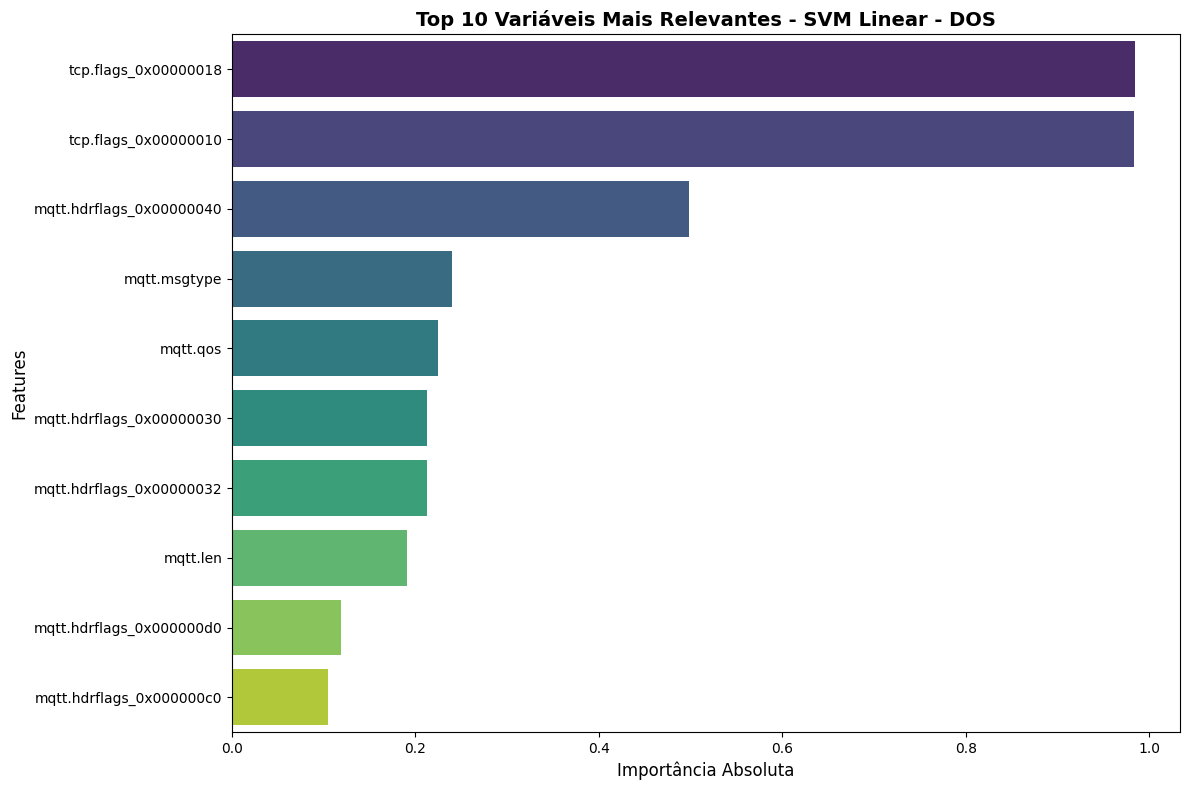


RELATÓRIO DE CLASSIFICAÇÃO - SVM Linear:
              precision    recall  f1-score   support

  Legitimate       0.82      1.00      0.90     49639
      Attack       1.00      0.72      0.83     39067

    accuracy                           0.87     88706
   macro avg       0.91      0.86      0.87     88706
weighted avg       0.90      0.87      0.87     88706



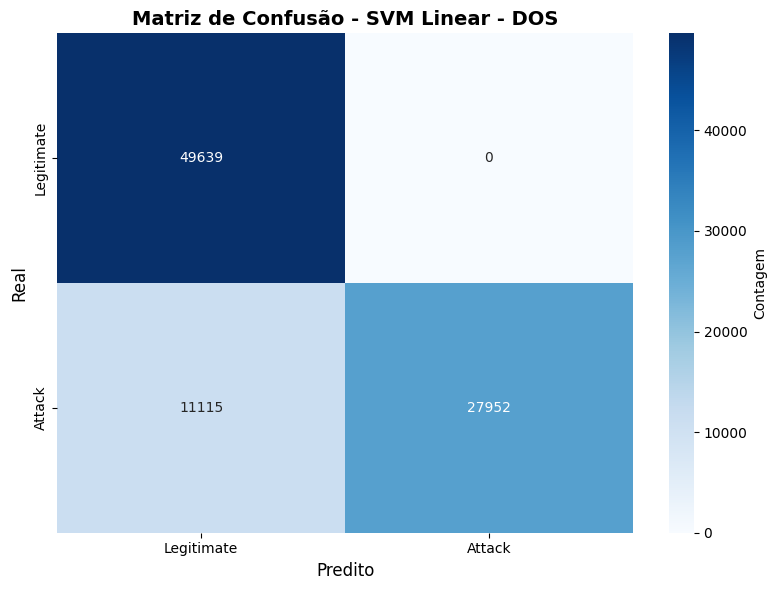

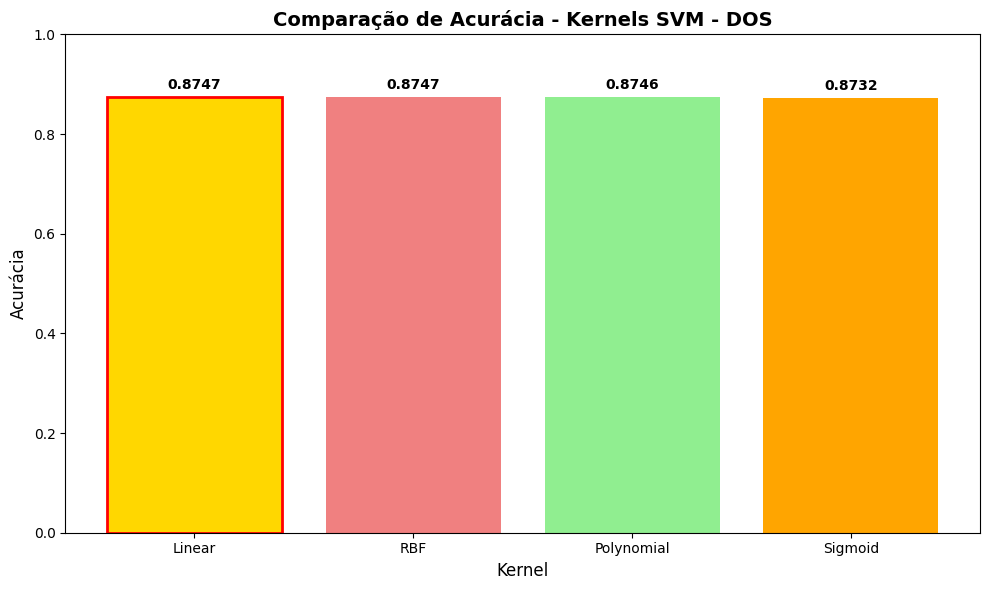


PARÂMETROS KNN - DOS
Número de vizinhos (n_neighbors): 5
Peso (weights): uniform
Métrica de distância: minkowski
Potência do parâmetro de Minkowski (p): 2

RELATÓRIO DE CLASSIFICAÇÃO - KNN - DOS
              precision    recall  f1-score   support

  Legitimate       0.95      0.98      0.96     49639
      Attack       0.98      0.93      0.95     39067

    accuracy                           0.96     88706
   macro avg       0.96      0.96      0.96     88706
weighted avg       0.96      0.96      0.96     88706


Acurácia KNN: 0.9589 (95.89%)

Top 10 features com maior diferença média entre classes (KNN) - DOS
mqtt.hdrflags_0x00000030: Diferença média = 1.3013
mqtt.qos: Diferença média = 1.0810
mqtt.len: Diferença média = 1.0158
mqtt.hdrflags_0x00000040: Diferença média = 0.8748
mqtt.hdrflags_0x00000032: Diferença média = 0.8412
tcp.len: Diferença média = 0.7680
mqtt.dupflag: Diferença média = 0.5949
mqtt.hdrflags_0x0000003a: Diferença média = 0.5949
tcp.flags_0x00000018: Diferenç

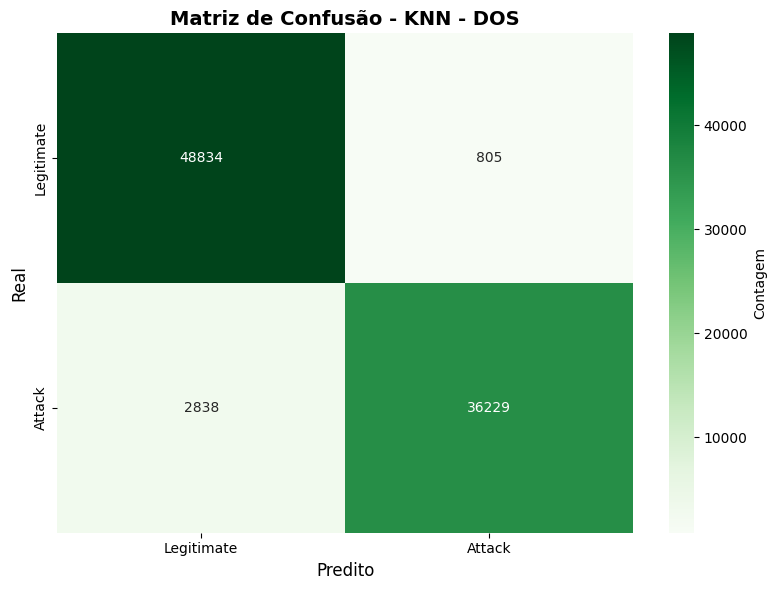


ANÁLISE PARA ATAQUE: FLOOD

COMPARAÇÃO DE KERNELS SVM - FLOOD
Linear       | Acurácia: 0.9980 (99.80%) | Params: {'kernel': 'linear', 'C': 1.0}
RBF          | Acurácia: 0.9981 (99.81%) | Params: {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'}
Polynomial   | Acurácia: 0.9980 (99.80%) | Params: {'kernel': 'poly', 'C': 1.0, 'degree': 3, 'gamma': 'scale'}
Sigmoid      | Acurácia: 0.9980 (99.80%) | Params: {'kernel': 'sigmoid', 'C': 1.0, 'gamma': 'scale'}

Melhor Kernel: RBF (Acurácia: 0.9981)

ANÁLISE DETALHADA - SVM RBF - FLOOD

Nota: Importância das features não disponível para kernel RBF

RELATÓRIO DE CLASSIFICAÇÃO - SVM RBF:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     49639
      Attack       1.00      0.47      0.64       184

    accuracy                           1.00     49823
   macro avg       1.00      0.74      0.82     49823
weighted avg       1.00      1.00      1.00     49823



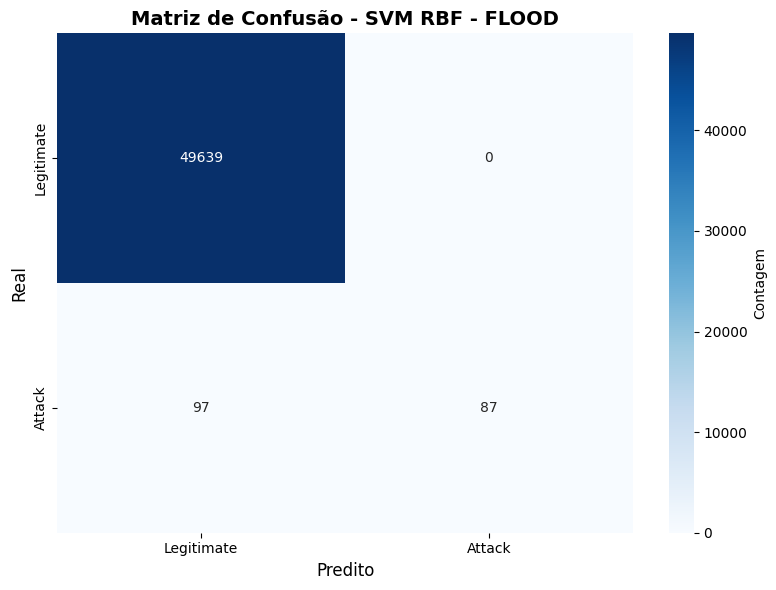

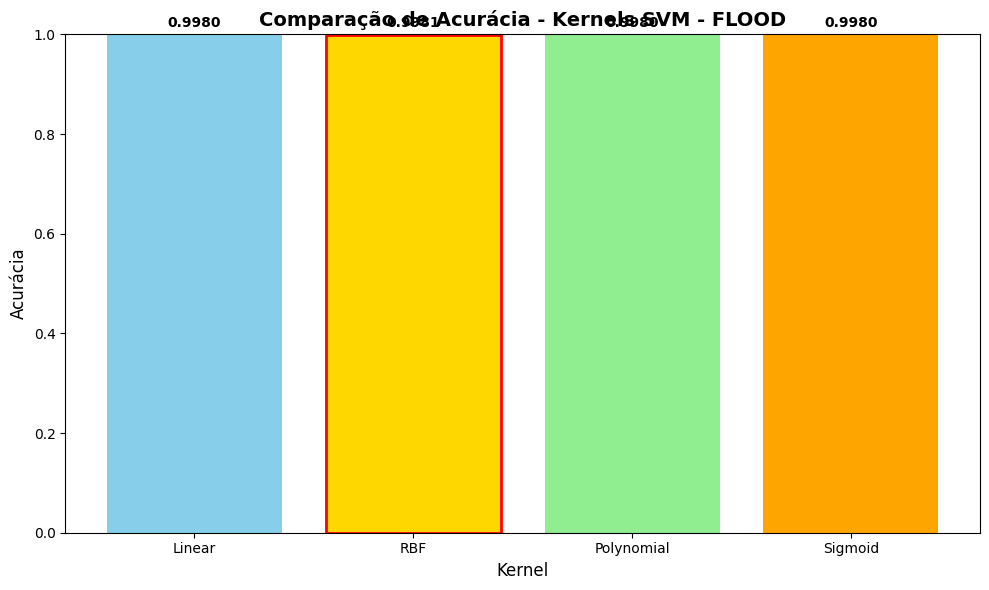


PARÂMETROS KNN - FLOOD
Número de vizinhos (n_neighbors): 5
Peso (weights): uniform
Métrica de distância: minkowski
Potência do parâmetro de Minkowski (p): 2

RELATÓRIO DE CLASSIFICAÇÃO - KNN - FLOOD
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     49639
      Attack       1.00      0.47      0.64       184

    accuracy                           1.00     49823
   macro avg       1.00      0.73      0.82     49823
weighted avg       1.00      1.00      1.00     49823


Acurácia KNN: 0.9980 (99.80%)

Top 10 features com maior diferença média entre classes (KNN) - FLOOD
tcp.len: Diferença média = 10.6094
mqtt.conack.flags_0x00000000: Diferença média = 2.2148
mqtt.hdrflags_0x00000020: Diferença média = 2.2148
tcp.flags_0x00000010: Diferença média = 0.3367
tcp.flags_0x00000018: Diferença média = 0.3367
mqtt.hdrflags_0x00000030: Diferença média = 0.3220
mqtt.msgtype: Diferença média = 0.3024
mqtt.len: Diferença média = 0.1107
mqtt.hdrfla

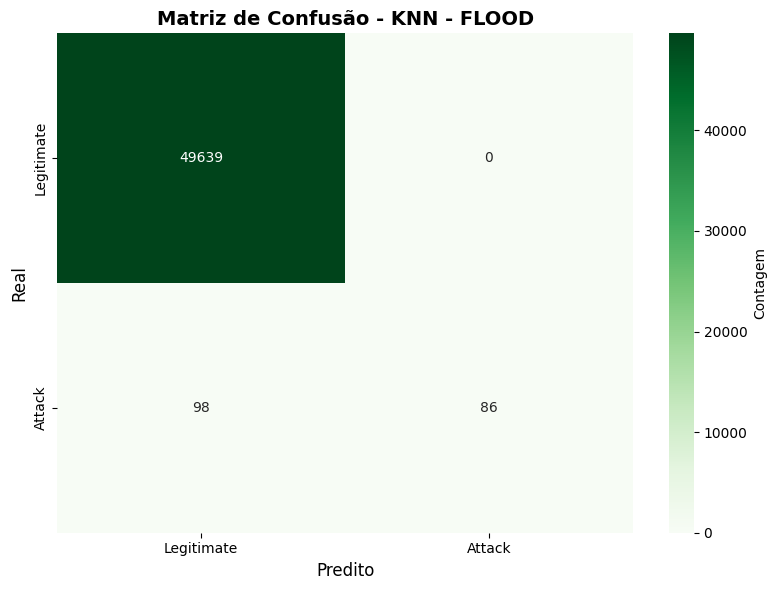


Análise concluída com sucesso!
Gráficos salvos em: plots/


In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Análise de Dataset MQTT para Detecção de Ataques
================================================

Este script realiza análise de segurança em dados de tráfego MQTT usando
algoritmos de Machine Learning (SVM e KNN) para detectar ataques DoS e Flood.

Autor: Análise de Segurança MQTT
Data: 2025
"""

import os
import sys
import warnings
import logging
from typing import Tuple, List, Optional, Dict, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Configurações globais
warnings.filterwarnings('ignore')
plt.style.use('default')  # Corrigido: seaborn-v0_8 pode não existir
sns.set_palette("husl")

# Configurar logging (apenas console)
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

# Constantes
DATASET_FILE = "mqttdataset_reduced.csv"
OUTPUT_DIR = "plots"
RANDOM_STATE = 42
TEST_SIZE = 0.3
FIGURE_SIZE = (12, 8)
DPI = 300

# === 1. Configuração e Preparação ===

def setup_environment():
    """Configura o ambiente de execução."""
    try:
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        logger.info(f"Diretório de saída criado: {OUTPUT_DIR}")

        # Verificar se o arquivo existe
        if not os.path.exists(DATASET_FILE):
            logger.error(f"Arquivo {DATASET_FILE} não encontrado!")
            sys.exit(1)

        logger.info("Ambiente configurado com sucesso")
    except Exception as e:
        logger.error(f"Erro ao configurar ambiente: {e}")
        sys.exit(1)

def get_selected_columns() -> List[str]:
    """
    Retorna as colunas selecionadas para análise.

    Returns:
        List[str]: Lista das colunas mais relevantes para o modelo
    """
    return [
        # Características TCP
        'tcp.flags', 'tcp.time_delta', 'tcp.len',

        # Características MQTT - Connection Acknowledgment
        'mqtt.conack.flags', 'mqtt.conack.val',

        # Características MQTT - Connection Flags
        'mqtt.conflag.cleansess', 'mqtt.conflag.passwd',
        'mqtt.conflag.qos', 'mqtt.conflag.retain',
        'mqtt.conflag.uname', 'mqtt.conflag.willflag',

        # Características MQTT - Gerais
        'mqtt.dupflag', 'mqtt.hdrflags', 'mqtt.kalive',
        'mqtt.len', 'mqtt.msgtype', 'mqtt.qos', 'mqtt.retain',
        'mqtt.sub.qos', 'mqtt.ver',

        # Target
        'target'
    ]

def load_and_preprocess_data(file_path: str, selected_columns: List[str]) -> pd.DataFrame:
    """
    Carrega e preprocessa o dataset.

    Args:
        file_path (str): Caminho para o arquivo CSV
        selected_columns (List[str]): Colunas a serem carregadas

    Returns:
        pd.DataFrame: Dataset preprocessado
    """
    try:
        logger.info(f"Carregando dataset: {file_path}")
        df = pd.read_csv(file_path, usecols=selected_columns, low_memory=False)

        logger.info(f"Dataset carregado: {df.shape[0]} linhas, {df.shape[1]} colunas")

        # Otimizar tipos de dados
        logger.info("Otimizando tipos de dados...")
        for col in df.columns:
            if col != 'target' and df[col].dtype in ['float64', 'int64']:
                df[col] = pd.to_numeric(df[col], errors='coerce').astype(np.float32)

        # Estatísticas básicas
        logger.info("Estatísticas do dataset:")
        logger.info(f"- Valores ausentes: {df.isnull().sum().sum()}")
        logger.info(f"- Tipos de ataques: {df['target'].value_counts().to_dict()}")

        return df

    except Exception as e:
        logger.error(f"Erro ao carregar dataset: {e}")
        raise

def prepare_data_for_target(df: pd.DataFrame, attack_type: str) -> Tuple[
    np.ndarray, np.ndarray, np.ndarray, np.ndarray, pd.Index
]:
    """
    Prepara os dados para um tipo específico de ataque.

    Args:
        df (pd.DataFrame): Dataset completo
        attack_type (str): Tipo de ataque ('dos' ou 'flood')

    Returns:
        Tuple: X_train, X_test, y_train, y_test, feature_names
    """
    logger.info(f"Preparando dados para ataque: {attack_type}")

    # Filtrar dados
    df_filtered = df[df['target'].isin(['legitimate', attack_type])].copy()
    logger.info(f"Amostras filtradas: {df_filtered.shape[0]}")

    # Codificar target
    df_filtered['target'] = df_filtered['target'].str.strip().str.lower().apply(
        lambda x: 0 if x == 'legitimate' else 1
    )

    # Remover valores ausentes
    initial_shape = df_filtered.shape[0]
    df_filtered.dropna(inplace=True)
    final_shape = df_filtered.shape[0]

    if initial_shape != final_shape:
        logger.warning(f"Removidas {initial_shape - final_shape} linhas com valores ausentes")

    # Separar features e target
    X = df_filtered.drop(columns=['target'])
    y = df_filtered['target'].astype(np.int8)

    # Encoding categórico
    X = pd.get_dummies(X, drop_first=True)
    logger.info(f"Features após encoding: {X.shape[1]}")

    # Normalização
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X).astype(np.float32)

    # Divisão treino/teste
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
    )

    logger.info(f"Divisão - Treino: {X_train.shape[0]}, Teste: {X_test.shape[0]}")
    logger.info(f"Distribuição target - Treino: {np.bincount(y_train)}, Teste: {np.bincount(y_test)}")

    return X_train, X_test, y_train, y_test, X.columns

def run_svm(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray,
           y_test: np.ndarray, feature_names: pd.Index, attack_type: str) -> Dict[str, Any]:
    """
    Executa análise com Support Vector Machine usando diferentes kernels.

    Args:
        X_train, X_test, y_train, y_test: Dados de treino e teste
        feature_names: Nomes das features
        attack_type: Tipo de ataque sendo analisado

    Returns:
        Dict[str, Any]: Resultados dos diferentes kernels
    """
    logger.info(f"Executando SVM com múltiplos kernels para {attack_type}")

    # Definir diferentes configurações de SVM
    svm_configs = {
        'Linear': {'kernel': 'linear', 'C': 1.0},
        'RBF': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
        'Polynomial': {'kernel': 'poly', 'C': 1.0, 'degree': 3, 'gamma': 'scale'},
        'Sigmoid': {'kernel': 'sigmoid', 'C': 1.0, 'gamma': 'scale'}
    }

    best_accuracy = 0
    best_kernel = None
    best_model = None
    results = {}

    print(f"\n{'='*60}")
    print(f"COMPARAÇÃO DE KERNELS SVM - {attack_type.upper()}")
    print(f"{'='*60}")

    # Testar cada kernel
    for kernel_name, params in svm_configs.items():
        try:
            logger.info(f"Testando kernel {kernel_name}")

            # Treinar modelo
            svm = SVC(random_state=RANDOM_STATE, **params)
            svm.fit(X_train, y_train)

            # Predições
            y_pred = svm.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)

            # Armazenar resultados
            results[kernel_name] = {
                'model': svm,
                'accuracy': accuracy,
                'predictions': y_pred,
                'params': params
            }

            # Verificar se é o melhor modelo
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_kernel = kernel_name
                best_model = svm

            print(f"{kernel_name:12} | Acurácia: {accuracy:.4f} ({accuracy*100:.2f}%) | Params: {params}")

        except Exception as e:
            logger.warning(f"Erro ao treinar kernel {kernel_name}: {e}")
            continue

    if best_model is None:
        logger.error("Nenhum modelo SVM foi treinado com sucesso")
        return {}

    print(f"\nMelhor Kernel: {best_kernel} (Acurácia: {best_accuracy:.4f})")

    # Análise detalhada do melhor modelo
    print(f"\n{'='*50}")
    print(f"ANÁLISE DETALHADA - SVM {best_kernel.upper()} - {attack_type.upper()}")
    print(f"{'='*50}")

    # Importância das features (apenas para kernel linear)
    if best_kernel == 'Linear':
        coef = best_model.coef_.flatten()
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Coef': coef,
            'Importance': np.abs(coef)
        }).sort_values(by='Importance', ascending=False)

        print(f"\nTop 10 features mais importantes:")
        print(feature_importance.head(10).to_string(index=False))

        # Plotar importância das features
        plt.figure(figsize=FIGURE_SIZE)
        sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature',
                   palette='viridis')
        plt.title(f'Top 10 Variáveis Mais Relevantes - SVM {best_kernel} - {attack_type.upper()}',
                 fontsize=14, fontweight='bold')
        plt.xlabel('Importância Absoluta', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/top10_features_svm_{best_kernel.lower()}_{attack_type}.png",
                   dpi=DPI, bbox_inches='tight')
        plt.show()
    else:
        print(f"\nNota: Importância das features não disponível para kernel {best_kernel}")

    # Relatório de classificação do melhor modelo
    best_predictions = results[best_kernel]['predictions']
    print(f"\nRELATÓRIO DE CLASSIFICAÇÃO - SVM {best_kernel}:")
    print(classification_report(y_test, best_predictions,
                              target_names=["Legitimate", "Attack"]))

    # Matriz de confusão do melhor modelo
    cm_svm = confusion_matrix(y_test, best_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Legitimate", "Attack"],
                yticklabels=["Legitimate", "Attack"],
                cbar_kws={'label': 'Contagem'})
    plt.title(f"Matriz de Confusão - SVM {best_kernel} - {attack_type.upper()}",
             fontsize=14, fontweight='bold')
    plt.xlabel("Predito", fontsize=12)
    plt.ylabel("Real", fontsize=12)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/confusion_matrix_svm_{best_kernel.lower()}_{attack_type}.png",
               dpi=DPI, bbox_inches='tight')
    plt.show()

    # Gráfico comparativo de acurácia dos kernels
    kernel_names = list(results.keys())
    accuracies = [results[k]['accuracy'] for k in kernel_names]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(kernel_names, accuracies, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
    plt.title(f'Comparação de Acurácia - Kernels SVM - {attack_type.upper()}',
             fontsize=14, fontweight='bold')
    plt.xlabel('Kernel', fontsize=12)
    plt.ylabel('Acurácia', fontsize=12)
    plt.ylim(0, 1)

    # Adicionar valores nas barras
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

    # Destacar o melhor kernel
    best_idx = kernel_names.index(best_kernel)
    bars[best_idx].set_color('gold')
    bars[best_idx].set_edgecolor('red')
    bars[best_idx].set_linewidth(2)

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/kernel_comparison_svm_{attack_type}.png",
               dpi=DPI, bbox_inches='tight')
    plt.show()

    logger.info(f"SVM para {attack_type} executado com sucesso. Melhor kernel: {best_kernel} (Acurácia: {best_accuracy:.4f})")

    return results

def run_knn(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray,
           y_test: np.ndarray, feature_names: Optional[pd.Index] = None,
           attack_type: str = 'attack') -> Dict[str, Any]:
    """
    Executa análise com K-Nearest Neighbors.

    Args:
        X_train, X_test, y_train, y_test: Dados de treino e teste
        feature_names: Nomes das features (opcional)
        attack_type: Tipo de ataque sendo analisado

    Returns:
        Dict[str, Any]: Resultados do modelo KNN
    """
    logger.info(f"Executando KNN para {attack_type}")

    try:
        # Treinar modelo
        knn = KNeighborsClassifier(n_neighbors=5, weights='uniform',
                                 metric='minkowski', p=2)
        knn.fit(X_train, y_train)

        print(f"\n{'='*50}")
        print(f"PARÂMETROS KNN - {attack_type.upper()}")
        print(f"{'='*50}")
        print(f"Número de vizinhos (n_neighbors): {knn.n_neighbors}")
        print(f"Peso (weights): {knn.weights}")
        print(f"Métrica de distância: {knn.metric}")
        print(f"Potência do parâmetro de Minkowski (p): {knn.p}")

        # Predições
        y_pred_knn = knn.predict(X_test)

        # Métricas
        print(f"\n{'='*50}")
        print(f"RELATÓRIO DE CLASSIFICAÇÃO - KNN - {attack_type.upper()}")
        print(f"{'='*50}")
        print(classification_report(y_test, y_pred_knn,
                                  target_names=["Legitimate", "Attack"]))

        accuracy = accuracy_score(y_test, y_pred_knn)
        print(f"\nAcurácia KNN: {accuracy:.4f} ({accuracy*100:.2f}%)")

        # Corrigido: identação do bloco if
        if feature_names is not None:
            print(f"\nTop 10 features com maior diferença média entre classes (KNN) - {attack_type.upper()}")

            # Recriar DataFrame dos dados de teste para análise
            X_test_df = pd.DataFrame(X_test, columns=feature_names)
            y_test_series = pd.Series(y_test).reset_index(drop=True)

            # Média por classe
            mean_legit = X_test_df[y_test_series == 0].mean()
            mean_attack = X_test_df[y_test_series == 1].mean()

            # Diferença absoluta
            diff = (mean_attack - mean_legit).abs().sort_values(ascending=False)

            top_features = diff.head(10)
            for feat, val in top_features.items():
                print(f"{feat}: Diferença média = {val:.4f}")

        # Matriz de confusão
        cm_knn = confusion_matrix(y_test, y_pred_knn)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens',
                    xticklabels=["Legitimate", "Attack"],
                    yticklabels=["Legitimate", "Attack"],
                    cbar_kws={'label': 'Contagem'})
        plt.title(f"Matriz de Confusão - KNN - {attack_type.upper()}",
                 fontsize=14, fontweight='bold')
        plt.xlabel("Predito", fontsize=12)
        plt.ylabel("Real", fontsize=12)
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/confusion_matrix_knn_{attack_type}.png",
                   dpi=DPI, bbox_inches='tight')
        plt.show()

        logger.info(f"KNN para {attack_type} executado com sucesso. Acurácia: {accuracy:.4f}")

        return {
            'model': knn,
            'accuracy': accuracy,
            'predictions': y_pred_knn
        }

    except Exception as e:
        logger.error(f"Erro ao executar KNN para {attack_type}: {e}")
        raise

def analyze_attack_type(df: pd.DataFrame, attack_type: str) -> Tuple[Dict[str, Any], Dict[str, Any]]:
    """
    Analisa um tipo específico de ataque com ambos os modelos.

    Args:
        df (pd.DataFrame): Dataset completo
        attack_type (str): Tipo de ataque a ser analisado

    Returns:
        Tuple[Dict[str, Any], Dict[str, Any]]: Resultados SVM e KNN
    """
    print(f"\n{'='*60}")
    print(f"ANÁLISE PARA ATAQUE: {attack_type.upper()}")
    print(f"{'='*60}")

    try:
        # Preparar dados
        X_train, X_test, y_train, y_test, feature_names = prepare_data_for_target(df, attack_type)

        # Executar modelos
        svm_results = run_svm(X_train, X_test, y_train, y_test, feature_names, attack_type)
        knn_results = run_knn(X_train, X_test, y_train, y_test, feature_names, attack_type)

        logger.info(f"Análise completa para {attack_type}")

        return svm_results, knn_results

    except Exception as e:
        logger.error(f"Erro na análise de {attack_type}: {e}")
        raise

def main():
    """Função principal do programa."""
    print("Iniciando Análise de Segurança MQTT")
    print("=" * 60)

    try:
        # Configurar ambiente
        setup_environment()

        # Obter colunas selecionadas
        selected_columns = get_selected_columns()
        logger.info(f"Colunas selecionadas: {len(selected_columns)}")

        # Carregar e preprocessar dados
        df = load_and_preprocess_data(DATASET_FILE, selected_columns)

        # Analisar ataques DoS
        dos_svm_results, dos_knn_results = analyze_attack_type(df, 'dos')

        # Analisar ataques Flood
        flood_svm_results, flood_knn_results = analyze_attack_type(df, 'flood')

        print(f"\n{'='*60}")
        print("Análise concluída com sucesso!")
        print(f"Gráficos salvos em: {OUTPUT_DIR}/")
        print(f"{'='*60}")

    except Exception as e:
        logger.error(f"Erro fatal na execução: {e}")
        sys.exit(1)

if __name__ == "__main__":
    main()

# Desvio Padrão

In [1]:
import pandas as pd

# Carrega o dataset
df = pd.read_csv("mqttdataset_reduced.csv")

# Parâmetro a ser analisado
parametro = 'tcp.len'  # ou 'mqtt.len', etc.

# Converte colunas para minúsculas
df.columns = df.columns.str.lower()
parametro_lower = parametro.lower()

# Verifica se o parâmetro existe no DataFrame
if parametro_lower in df.columns:
    # Converte a coluna para valores numéricos (se necessário)
    if not pd.api.types.is_numeric_dtype(df[parametro_lower]):
        df[parametro_lower] = pd.to_numeric(df[parametro_lower], errors='coerce')

    # Remove valores ausentes
    df_validos = df[df[parametro_lower].notna()]

    if not df_validos.empty:
        print("=" * 50)
        print(f"ANÁLISE GLOBAL DO PARÂMETRO: {parametro}")
        print("=" * 50)

        media = df_validos[parametro_lower].mean()
        desvio = df_validos[parametro_lower].std()
        count = len(df_validos)

        print(f"Total de registros válidos: {count}")
        print(f"Média: {media:.2f}")
        print(f"Desvio padrão: {desvio:.2f}")
        print("=" * 50)
    else:
        print(f"Todos os valores em '{parametro}' estão ausentes ou inválidos.")
else:
    print(f"Coluna '{parametro}' não encontrada no DataFrame.")
    print(f"Colunas disponíveis: {list(df.columns)}")


ANÁLISE GLOBAL DO PARÂMETRO: tcp.len
Total de registros válidos: 330926
Média: 152.59
Desvio padrão: 945.50


In [2]:
import pandas as pd

# Carrega o dataset
df = pd.read_csv("mqttdataset_reduced.csv")

# Parâmetro a ser analisado
parametro = 'tcp.len'  # ou 'mqtt.len', etc.

# Converte colunas para minúsculas
df.columns = df.columns.str.lower()
parametro_lower = parametro.lower()

# Verifica se a coluna target existe
if 'target' in df.columns:
    # Converte a coluna target para minúsculo
    df['target'] = df['target'].str.lower()

    # -------------------------------
    # ANÁLISE DOS DADOS LEGÍTIMOS
    # -------------------------------
    legitimos = df[df['target'] == 'legitimate']

    if parametro_lower in legitimos.columns:
        if not pd.api.types.is_numeric_dtype(legitimos[parametro_lower]):
            legitimos[parametro_lower] = pd.to_numeric(legitimos[parametro_lower], errors='coerce')

        legitimos_validos = legitimos[legitimos[parametro_lower].notna()]

        if not legitimos_validos.empty:
            print("=" * 50)
            print(f"ANÁLISE DO PARÂMETRO: {parametro} (APENAS LEGÍTIMOS)")
            print("=" * 50)

            media = legitimos_validos[parametro_lower].mean()
            desvio = legitimos_validos[parametro_lower].std()
            count = len(legitimos_validos)

            print(f"Registros: {count}")
            print(f"Média: {media:.2f}")
            print(f"Desvio padrão: {desvio:.2f}")
            print("=" * 50)
        else:
            print(f"Todos os valores válidos em '{parametro}' estão ausentes ou inválidos para registros legítimos.")
    else:
        print(f"Coluna '{parametro}' não encontrada no DataFrame.")
        print(f"Colunas disponíveis: {list(df.columns)}")

    # -------------------------------
    # ANÁLISE DOS DADOS DE ATAQUES
    # -------------------------------
    ataques = df[df['target'] != 'legitimate']

    if parametro_lower in ataques.columns:
        if not pd.api.types.is_numeric_dtype(ataques[parametro_lower]):
            ataques[parametro_lower] = pd.to_numeric(ataques[parametro_lower], errors='coerce')

        ataques_validos = ataques[ataques[parametro_lower].notna()]

        if not ataques_validos.empty:
            print("=" * 50)
            print(f"ANÁLISE DO PARÂMETRO: {parametro} (TODOS OS ATAQUES)")
            print("=" * 50)

            tipos_ataque = ataques_validos['target'].unique()

            for tipo in tipos_ataque:
                dados_tipo = ataques_validos[ataques_validos['target'] == tipo]
                media = dados_tipo[parametro_lower].mean()
                desvio = dados_tipo[parametro_lower].std()
                count = len(dados_tipo)

                print(f"\n--- {tipo.upper()} ---")
                print(f"Registros: {count}")
                print(f"Média: {media:.2f}")
                print(f"Desvio padrão: {desvio:.2f}")

            # Análise geral de todos os ataques
            media_geral = ataques_validos[parametro_lower].mean()
            desvio_geral = ataques_validos[parametro_lower].std()
            count_geral = len(ataques_validos)

            print(f"\n--- GERAL (TODOS OS ATAQUES) ---")
            print(f"Registros: {count_geral}")
            print(f"Média: {media_geral:.2f}")
            print(f"Desvio padrão: {desvio_geral:.2f}")
            print("=" * 50)
        else:
            print(f"Todos os valores válidos em '{parametro}' estão ausentes ou inválidos para registros de ataque.")
    else:
        print(f"Coluna '{parametro}' não encontrada entre os ataques.")
else:
    print("Coluna 'target' não encontrada no DataFrame.")
    print(f"Colunas disponíveis: {list(df.columns)}")


ANÁLISE DO PARÂMETRO: tcp.len (APENAS LEGÍTIMOS)
Registros: 165463
Média: 7.82
Desvio padrão: 6.19
ANÁLISE DO PARÂMETRO: tcp.len (TODOS OS ATAQUES)

--- DOS ---
Registros: 130223
Média: 312.68
Desvio padrão: 557.31

--- SLOWITE ---
Registros: 9202
Média: 4.00
Desvio padrão: 8.99

--- MALFORMED ---
Registros: 10924
Média: 20.97
Desvio padrão: 133.18

--- BRUTEFORCE ---
Registros: 14501
Média: 3.99
Desvio padrão: 29.14

--- FLOOD ---
Registros: 613
Média: 13313.42
Desvio padrão: 15204.73

--- GERAL (TODOS OS ATAQUES) ---
Registros: 165463
Média: 297.37
Desvio padrão: 1321.36
